In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
import h5py


In [2]:
!pwd

/home/breuer/git/preplanning/src/preplanning/postprocessing


In [2]:

os.chdir("../../../")



In [3]:
plt.style.use("FST.mplstyle")

In [4]:
# Specify the directory containing the .h5 files
directory = "new_solutions/real_GPZ/preplanning/distributed/"

# Iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".h5"):
        file_path = os.path.join(directory, filename)
        try:
            with h5py.File(file_path, 'r') as h5_file:
                # Check if 'comment' dataset exists
                if "Comment" in h5_file:
                    comment_data = h5_file["Comment"][()]
                    print(f"File: {filename}")
                    print(f"Comment: {comment_data.decode() if isinstance(comment_data, bytes) else comment_data}\n")
                else:
                    print(f"File: {filename} - No 'comment' dataset found.\n")
        except Exception as e:
            print(f"Error reading {filename}: {e}")


File: 2a83e75a-7995-44a9-97c8-0f0919636428.h5
Comment: distributed, min lcc

File: af437068-34a5-49ce-b6f3-207522c5202b.h5
Comment: distributed, min energy costs

File: 25555078-34a8-49e8-8b23-254294638c52.h5
Comment: distributedmin invest costs

File: 2c9a5601-88db-443c-8a55-2185bb9c8118.h5
Comment: distributed, energy costs ub: 6500.0

File: ac70554b-74dd-4e2b-b84e-d0a1d01beee0.h5
Comment: distributed, energy costs ub: 7000.0

File: 92f6d1b2-c25a-48e8-8b07-aa70ac7252ef.h5
Comment: distributed, energy costs ub: 5500.0

File: 478bc877-d6a8-4ec9-8cb7-0e54e9a41817.h5
Comment: distributed, invest costs ub: 35000.0, proven to be infeasible

File: 4f9983fc-e1a3-4469-8942-079fa537ebea.h5
Comment: distributed, energy costs ub: 6000.0



In [5]:
def contains_string(file_path, target_string):
    with h5py.File(file_path, 'r') as f:
        def recursive_search(h5_obj):
            if isinstance(h5_obj, h5py.Dataset):
                # If dataset contains ASCII strings
                if h5_obj.dtype.kind in {'S', 'O'}:  # S = bytes, O = object (e.g. variable length strings)
                    data = h5_obj[()]
                    if isinstance(data, bytes):
                        return target_string in data.decode()
                    elif isinstance(data, str):
                        return target_string in data
                    elif isinstance(data, (list, tuple, np.ndarray)):
                        # iterate over each item
                        return any(
                            (target_string in d.decode() if isinstance(d, bytes) else target_string in d)
                            for d in data
                        )
            elif isinstance(h5_obj, h5py.Group):
                for key in h5_obj:
                    if recursive_search(h5_obj[key]):
                        return True
            return False
        
        return recursive_search(f)

In [6]:
import h5py
import os

def extract_h5_data(folder_path):

    excluded_folders = {"old", "with_max_load_case_but_no_underestimation_of_ploss", "without_all_VFC_or_all_fan_constraint_no_max_load_case"}

    data_dict = {}

    # Iterate through all files in the folder
    # for file_name in os.listdir(folder_path):
    for root, dirs, files in os.walk(folder_path):
        dirs[:] = [d for d in dirs if d not in excluded_folders]
        for file_name in files:
            file_path = os.path.join(root, file_name)
            if file_path.endswith(".h5"):  # Ensure it's an HDF5 file
                # file_path = os.path.join(folder_path, file_name)
                try:
                    with h5py.File(file_path, "r") as h5_file:
                        if "Expression" in h5_file["Optimisation Components"]:  # Check if 'expression' group exists
                            expression_group = h5_file["Optimisation Components"]["Expression"]
                            invest_costs = None
                            power_consumption = None
                            exact_power_consumption, exact_lcc = None, None
                            duct_costs, vfc_costs, fan_costs = None, None, None
                            duct_volume = None
                            optimality_gap = None
                            computation_time = None

                            if "all_fans" in file_name:
                                invest_cost_lower = 116e3*1.47
                            else:
                                invest_cost_lower = 0

                            # Access the subdatasets under 'expression'

                            # Extract invest_costs if available
                            if "total_invest_costs" in expression_group:
                                dataset = expression_group["total_invest_costs"]
                                invest_costs = dataset[0]["value"] - invest_cost_lower

                            # Extract operating_costs if available
                            if "fan_power_consumption" in expression_group:
                                dataset = expression_group["fan_power_consumption"]
                                power_consumption = dataset[0]["value"]

                            if "fan_energy_costs" in expression_group:
                                dataset = expression_group["fan_energy_costs"]
                                fan_energy_costs = dataset[0]["value"]

                            if "Exact Power Consumption" in h5_file["Postprocessing"]:
                                dataset = h5_file["Postprocessing"]["Exact Power Consumption" ]
                                exact_power_consumption = dataset[()]

                            if "Wallclock time" in h5_file["Solver"]:
                                dataset = h5_file["Solver"]["Wallclock time" ]
                                computation_time = dataset[()]


                            if "Exact Life-Cycle Costs" in h5_file["Postprocessing"]:
                                dataset = h5_file["Postprocessing"]["Exact Life-Cycle Costs" ]
                                exact_lcc = dataset[()]

                            if "total_duct_costs" in expression_group:
                                dataset = expression_group["total_duct_costs"]
                                duct_costs = dataset[0]["value"]

                            if "total_vfc_costs" in expression_group:
                                dataset = expression_group["total_vfc_costs"]
                                vfc_costs = dataset[0]["value"]

                            if "total_fan_costs" in expression_group:
                                dataset = expression_group["total_fan_costs"]
                                fan_costs = dataset[0]["value"]

                            if "duct_volume" in expression_group:
                                dataset = expression_group["duct_volume"]
                                duct_volume = dataset[0]["value"]

                            if "fan_ind_purchase" in h5_file["Optimisation Components"]["Variable"]:
                                dataset = h5_file["Optimisation Components"]["Variable"]["fan_ind_purchase"][:]
                                fan_ind_purchase = dict(zip([x.decode("utf-8") for x in dataset["fan_set"]], dataset["value"]))


                            if "Problem Definition" in h5_file:
                                lb = h5_file["Problem Definition"]["Lower bound"][()]
                                ub = h5_file["Problem Definition"]["Upper bound"][()]
                                postprocess_gap = (ub-lb)/lb


                            if "Solver" in h5_file and "Log" in h5_file["Solver"]:
                                log_data = h5_file["Solver"]["Log"][()]

                                # Handle string types and arrays
                                found = False
                                if isinstance(log_data, bytes):
                                    found = "Optimal solution found" in log_data.decode()
                                elif isinstance(log_data, str):
                                    found = "Optimal solution found" in log_data
                                elif isinstance(log_data, (list, tuple, np.ndarray)):
                                    found = any(
                                        ("Optimal solution found" in d.decode() if isinstance(d, bytes)
                                        else "Optimal solution found" in d)
                                        for d in log_data
                                    )

                                if found:
                                    optimality_gap = 0
                                else:
                                    optimality_gap = h5_file["Solver"]["Convergence"][-1]["Gap in %"]



                            # Store values in dictionary
                            data_dict[file_name] = {
                                "invest_costs": invest_costs,
                                "power_consumption": power_consumption,
                                "exact_power_consumption": exact_power_consumption,
                                "duct_costs": duct_costs,
                                "vfc_costs": vfc_costs,
                                "fan_costs": fan_costs,
                                "duct_volume": duct_volume,
                                "fan_ind_purchase": fan_ind_purchase,
                                "fan_energy_costs": fan_energy_costs,
                                "postprocess_gap": postprocess_gap,
                                "optimality_gap": optimality_gap,
                                "exact_lcc": exact_lcc,
                                "computation_time": computation_time,
                            }

                except Exception as e:
                    print(f"Error processing {folder_path}/{file_name}: {e}")

    return data_dict


folder = "new_solutions/real_GPZ/preplanning/"

foldernames = ["central CPC/", "central/", "distributed/", "distributed CPC/", "distributed VPC/", "fully distributed/"]
foldernames = ["central CPC/", "central/", "distributed CPC/", "fully distributed/", "distributed/"]
# foldernames = ["central CPC/", "central/", "distributed CPC/", "fully distributed/", "distributed/", "no_velocity_limit/central/", "no_velocity_limit/distributed/", "velocity_limit_3/distributed/", "velocity_limit_7/distributed/"]
result_list = [extract_h5_data(folder + x) for x in foldernames]



Error processing new_solutions/real_GPZ/preplanning/central CPC//81edd0b8-4337-4606-9c9f-0b79a9eb88e2.h5: "Unable to synchronously open object (object 'Optimisation Components' doesn't exist)"
Error processing new_solutions/real_GPZ/preplanning/central CPC//deb3da2f-4d2d-4abf-95be-522b6d2e26e2.h5: "Unable to synchronously open object (object 'Optimisation Components' doesn't exist)"
Error processing new_solutions/real_GPZ/preplanning/central//7b2b501f-9828-4778-86fa-f3709abe791f.h5: "Unable to synchronously open object (object 'Optimisation Components' doesn't exist)"
Error processing new_solutions/real_GPZ/preplanning/central//f0274d7c-6d9c-4806-a1e7-e5ab2484f630.h5: "Unable to synchronously open object (object 'Optimisation Components' doesn't exist)"
Error processing new_solutions/real_GPZ/preplanning/distributed CPC//263cc867-135e-4495-b1e1-facb2897f6ba.h5: "Unable to synchronously open object (object 'Optimisation Components' doesn't exist)"
Error processing new_solutions/real_GPZ

In [7]:
# from collections import defaultdict

# def transpose_dict_of_dicts(data):
#     result = defaultdict(list)
#     for outer_key in data:
#         for inner_key, value in data[outer_key]["fan_ind_purchase"].items():
#             result[inner_key].append(value)
#     return dict(result)

# transposed = transpose_dict_of_dicts(result_list[-1])
# plt.imshow(np.array([x for x in transposed.values()]), aspect="auto")


# # yticks = result_list[-1]['be80e77b-daee-4cfd-b042-c524aa503d3f.h5']["fan_ind_purchase"].keys()

# # _ = plt.yticks(range(len(yticks)), yticks, fontsize=2)

In [12]:
def process_dicts(dict_from_h5):
    # Get all keys (like 'invest_costs', etc.) from one of the entries
    value_keys = list(next(iter(dict_from_h5.values())).keys())

    # For each key, collect all values across the dicts
    collected = {key: [entry[key] for entry in dict_from_h5.values()] for key in value_keys}

    # Sort by the first metric (e.g., 'invest_costs')
    sort_key = value_keys[2]
    sorted_indices = np.argsort(collected[sort_key])

    # Build a sorted output dictionary
    sorted_dict = {
        key: np.array(values)[sorted_indices]
        for key, values in collected.items()
    }

    return sorted_dict

standard_dict_list = []
for curr_dict in result_list:
    standard_dict_list.append(process_dicts(curr_dict))

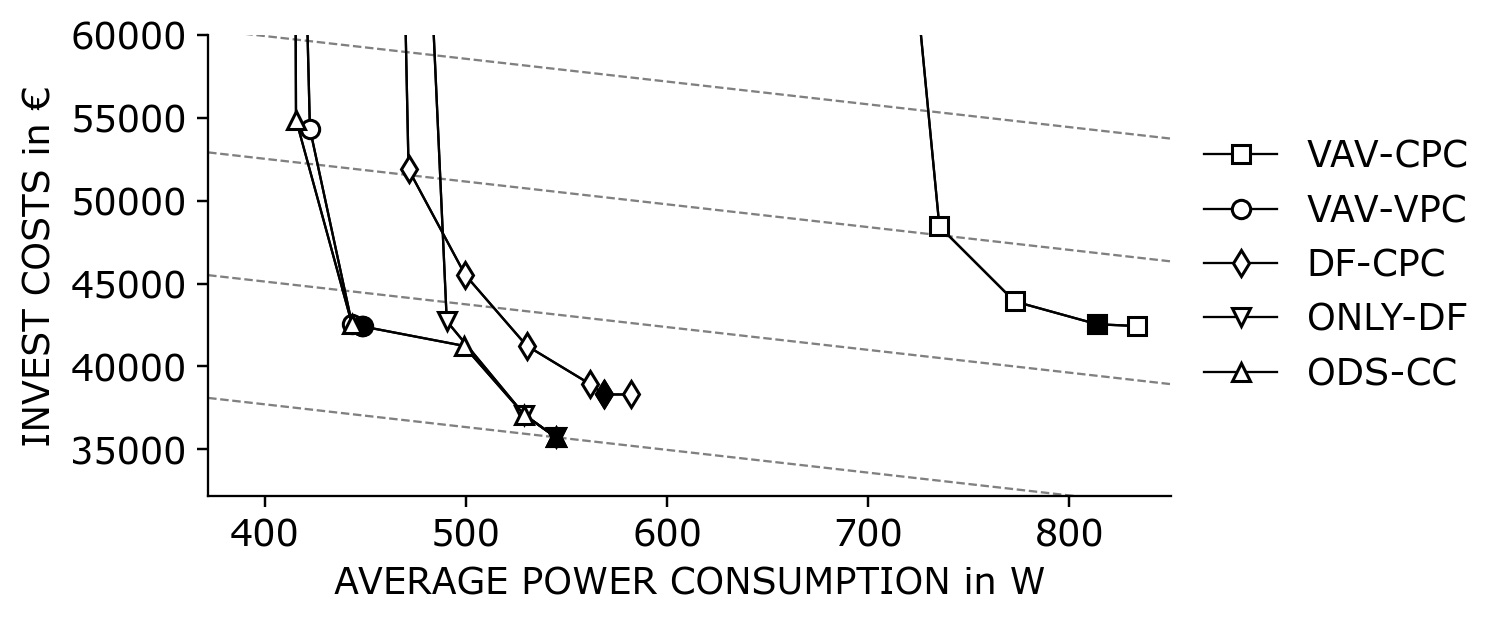

In [13]:
from src.preplanning.postprocessing.utils import find_absolute_min_max

markerstyle = ["s","o","d","v","^","x","*", "p", "h", "H"]

cs_names = ["VAV-CPC", "VAV-VPC", "DF-CPC", "ONLY-DF", "ODS-CC"]

fig,ax = plt.subplots(figsize=(7,3))

for idx, curr_dict in enumerate(standard_dict_list):
    plt.plot(curr_dict["exact_power_consumption"],curr_dict["invest_costs"], "-", color="k", markeredgecolor="k")
    plt.plot(curr_dict["exact_power_consumption"],curr_dict["invest_costs"], color="k", marker=markerstyle[idx],markerfacecolor="white", markeredgecolor="k", label=cs_names[idx])
    min_lcc = np.argmin(curr_dict["exact_lcc"])
    plt.plot([curr_dict["exact_power_consumption"][min_lcc]], [curr_dict["invest_costs"][min_lcc]], markerstyle[idx], markeredgecolor="k", markerfacecolor="k")

    min_energy_arg = np.argmin(curr_dict["exact_power_consumption"])
    min_invest_arg = np.argmin(curr_dict["invest_costs"])

    # plt.plot([curr_dict["exact_power_consumption"][min_invest_arg],3e9], [curr_dict["invest_costs"][min_invest_arg]]*2, "black")
    # plt.plot([curr_dict["exact_power_consumption"][min_invest_arg]]*2,[curr_dict["invest_costs"][min_invest_arg],3e9], "black")    
 

min_power, max_power = find_absolute_min_max(standard_dict_list, "exact_power_consumption")

min_lcc, max_lcc = find_absolute_min_max(standard_dict_list, "exact_lcc")

min_invest, max_invest = find_absolute_min_max(standard_dict_list, "invest_costs")


plt.ylabel("INVEST COSTS in €")
plt.xlabel("AVERAGE POWER CONSUMPTION in W")

x = np.array([min_power*0.9,max_power*1.02])

power_to_cost = 8e3 / 582

for i in np.linspace(min_lcc, max_lcc, 15):
    plt.plot(x,i - power_to_cost*x, "--",color="grey",zorder=-1)

plt.xlim(min_power*0.9, max_power*1.02)
# plt.ylim(min_invest*0.9, max_invest*1.02)
plt.ylim(min_invest*0.9, 60e3)

# plt.legend(["VAV-CPC", "VAV-VPC", "DF-CPC", "ONLY-DF", "ODS-CC"])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()

# save_fig_as_emf(fig, "plots/fan2025/pareto_front_all.emf")

# plt.savefig("plots/full_paper/pareto.svg")
# plt.savefig("plots/full_paper/pareto.png")
# plt.savefig("plots/full_paper/pareto.pdf")

In [14]:
foldernames = ["cav", "central CPC/", "central/", "distributed CPC/", "fully distributed/", "distributed/"]

cs_names = ["CAV", "VAV-CPC", "VAV-VPC", "DF-CPC", "ONLY-DF", "ODS-CC"]

# foldernames = ["cav", "central CPC/", "central/", "distributed CPC/", "fully distributed/", "distributed/", "no_velocity_limit/central/", "velocity_limit_3/central/", "velocity_limit_7/central/", "velocity_limit_9/central/",  "no_velocity_limit/distributed/", "velocity_limit_3/distributed/", "velocity_limit_7/distributed/", "velocity_limit_9/distributed/"]

# cs_names = ["CAV", "VAV-CPC", "VAV-VPC", "DF-CPC", "DF", "ODS-CC", "no_vel VAV-VPC", "vel3 VAV-VPC", "vel7 VAV_VPC", "vel9 VAV_VPC", "no_vel ODS-CC", "vel3 ODS-CC", "vel7 ODS-CC", "vel9 ODS-CC"]

## velocities

# foldernames = [ "velocity_limit_3/central/","central/",  "velocity_limit_7/central/", "velocity_limit_9/central/", "no_velocity_limit/central/",  "velocity_limit_3/distributed/",  "distributed/", "velocity_limit_7/distributed/", "velocity_limit_9/distributed/", "no_velocity_limit/distributed/",]

# cs_names = [ "3", "5", "7", "9", "$\infty$"]*2

# ## max height

# foldernames = [ "central/", "max_height_03/central/", "max_height_025/central/",    "distributed/",   "max_height_03/distributed/", "max_height_025/distributed/"]

# cs_names = ["0.6", "0.3", "0.25", "0.6", "0.3", "0.25"]


result_list = [extract_h5_data(folder + x) for x in foldernames]


standard_dict_list = []
for curr_dict in result_list:
    standard_dict_list.append(process_dicts(curr_dict))

Error processing new_solutions/real_GPZ/preplanning/central CPC//81edd0b8-4337-4606-9c9f-0b79a9eb88e2.h5: "Unable to synchronously open object (object 'Optimisation Components' doesn't exist)"
Error processing new_solutions/real_GPZ/preplanning/central CPC//deb3da2f-4d2d-4abf-95be-522b6d2e26e2.h5: "Unable to synchronously open object (object 'Optimisation Components' doesn't exist)"
Error processing new_solutions/real_GPZ/preplanning/central//7b2b501f-9828-4778-86fa-f3709abe791f.h5: "Unable to synchronously open object (object 'Optimisation Components' doesn't exist)"
Error processing new_solutions/real_GPZ/preplanning/central//f0274d7c-6d9c-4806-a1e7-e5ab2484f630.h5: "Unable to synchronously open object (object 'Optimisation Components' doesn't exist)"
Error processing new_solutions/real_GPZ/preplanning/distributed CPC//263cc867-135e-4495-b1e1-facb2897f6ba.h5: "Unable to synchronously open object (object 'Optimisation Components' doesn't exist)"
Error processing new_solutions/real_GPZ

## LCC Bar charts

In [15]:
height_plot = False
if height_plot:

    # Assume colors are in hex RGBA
    colors = ['#000000ff', '#535353ff', '#898989ff', '#b5b5b5ff', '#dcdcdcff']

    # Compute indices of maximum LCC
    from src.preplanning.postprocessing.utils import find_strategy_arg_min_max
    arg_max_lcc, _ = find_strategy_arg_min_max(standard_dict_list, "exact_lcc")

    # Plot setup
    fig, ax = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

    entry_names = ["duct_costs", "vfc_costs", "fan_costs", "exact_fan_energy_costs"]
    cost_label = ["DUCT INVEST", "VFC INVEST", "FAN INVEST", "FAN ENERGY"]

    # Iterate over strategies
    for idx, curr_dict in enumerate(standard_dict_list):
        # Compute exact fan energy costs
        curr_dict["exact_fan_energy_costs"] = (
            curr_dict["fan_energy_costs"]
            * curr_dict["exact_power_consumption"]
            / curr_dict["power_consumption"]
        )

        # Extract relevant costs at arg_max_lcc index
        costs = [curr_dict[name][arg_max_lcc[idx]] for name in entry_names]

        # Plot stacked bar
        b_cost = 0
        if idx < 3:
            for i, cost in enumerate(costs):
                ax[0].bar(cs_names[idx], cost, bottom=b_cost, color=colors[i], label=cost_label[i])
                b_cost += cost
        else:
            for i, cost in enumerate(costs):
                ax[1].bar(cs_names[idx], cost, bottom=b_cost, color=colors[i], label=cost_label[i])
                b_cost += cost
        
        print(np.sum(costs))
    # Optional: Customize axes
    ax[0].set_ylabel("LIFE-CYCLE COSTS in €")
    ax[1].legend(entry_names)
    _ = ax[0].set_xticks(cs_names, cs_names)

    ax[0].set_title("VAV-VPC")
    ax[1].set_title("ODS-CC")

    ax[0].set_xlabel("MAX HEIGHT in m")
    ax[1].set_xlabel("MAX HEIGHT in m")


    handles, labels = ax[1].get_legend_handles_labels()
    custom_order = [3, 2, 1, 0]  # Index-Reihenfolge: FAN ENERGY, FAN INVEST, VFC INVEST, DUCT INVEST
    ax[1].legend([handles[i] for i in custom_order], [labels[i] for i in custom_order],
            loc='center left', bbox_to_anchor=(1, 0.5))

    fig.tight_layout()


    # fig.savefig("plots/full_paper/bar_chart_max_height.svg")
    # fig.savefig("plots/full_paper/bar_chart_max_height.pdf")
    # fig.savefig("plots/full_paper/bar_chart_max_height.png")

43649.742466735246
11178.63341593191
6156.26247393505
7808.830892961617
7479.329116911362
7479.329116911363


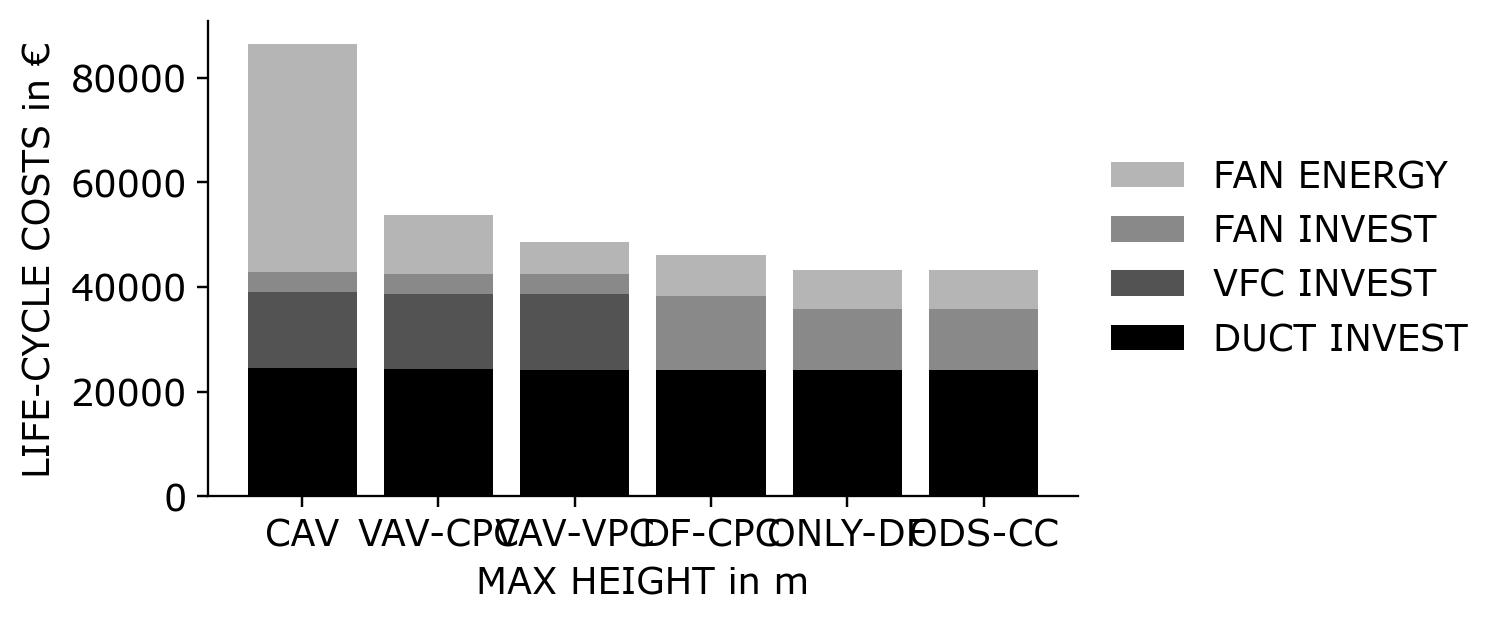

In [16]:
import matplotlib.pyplot as plt

# Assume colors are in hex RGBA
colors = ['#000000ff', '#535353ff', '#898989ff', '#b5b5b5ff', '#dcdcdcff']

# Compute indices of maximum LCC
from src.preplanning.postprocessing.utils import find_strategy_arg_min_max
arg_max_lcc, _ = find_strategy_arg_min_max(standard_dict_list, "exact_lcc")

# Plot setup
fig, ax = plt.subplots(1, 1, figsize=(7, 3), sharey=True)

entry_names = ["duct_costs", "vfc_costs", "fan_costs", "exact_fan_energy_costs"]
cost_label = ["DUCT INVEST", "VFC INVEST", "FAN INVEST", "FAN ENERGY"]

# Iterate over strategies
for idx, curr_dict in enumerate(standard_dict_list):
    # Compute exact fan energy costs
    curr_dict["exact_fan_energy_costs"] = (
        curr_dict["fan_energy_costs"]
        * curr_dict["exact_power_consumption"]
        / curr_dict["power_consumption"]
    )

    # Extract relevant costs at arg_max_lcc index
    costs = [curr_dict[name][arg_max_lcc[idx]] for name in entry_names]

    # Plot stacked bar
    b_cost = 0
    for i, cost in enumerate(costs):
        ax.bar(cs_names[idx], cost, bottom=b_cost, color=colors[i], label=cost_label[i])
        b_cost += cost

    print(costs[-1]) # print duct costs
# Optional: Customize axes
ax.set_ylabel("LIFE-CYCLE COSTS in €")
ax.legend(entry_names)
_ = ax.set_xticks(cs_names, cs_names)


ax.set_xlabel("MAX HEIGHT in m")


handles, labels = ax.get_legend_handles_labels()
custom_order = [3, 2, 1, 0]  # Index-Reihenfolge: FAN ENERGY, FAN INVEST, VFC INVEST, DUCT INVEST
ax.legend([handles[i] for i in custom_order], [labels[i] for i in custom_order],
          loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()


# fig.savefig("plots/full_paper/bar_chart_max_height.svg")
# fig.savefig("plots/full_paper/bar_chart_max_height.pdf")
# fig.savefig("plots/full_paper/bar_chart_max_height.png")

## Optimality gaps for different control strategies

In [30]:
# from src.preplanning.postprocessing.utils import find_absolute_min_max

# markerstyle = ["s","o","d","v","^","x","*", "p", "h", "H"]

# fig,ax = plt.subplots(figsize=(6,4))

# for idx, curr_dict in enumerate(standard_dict_list):
#     if idx == 0:
#         continue

#     mip_gap = curr_dict["power_consumption"] * curr_dict["optimality_gap"]/100
#     approx_error =  curr_dict["exact_power_consumption"] - curr_dict["power_consumption"]

#     plt.errorbar(curr_dict["power_consumption"],curr_dict["invest_costs"], xerr = [mip_gap, approx_error], fmt='-o', markersize=3, capsize=5, color= "k")


# plt.ylabel("INVEST COSTS in €")
# plt.xlabel("AVERAGE POWER CONSUMPTION in W")


# fig.tight_layout()

# # fig.savefig("plots/full_paper/errorbar_pareto.svg")
# # fig.savefig("plots/full_paper/errorbar_pareto.pdf")
# # fig.savefig("plots/full_paper/errorbar_pareto.png")

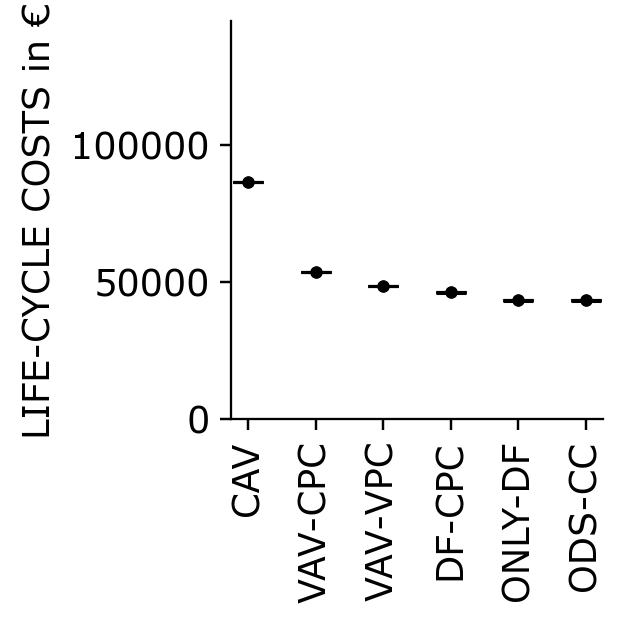

In [17]:
import matplotlib.pyplot as plt

# Assume colors are in hex RGBA
colors = ['#000000ff', '#535353ff', '#898989ff', '#b5b5b5ff',  '#dcdcdcff']

# Compute indices of maximum LCC
from src.preplanning.postprocessing.utils import find_strategy_arg_min_max
arg_max_lcc, _ = find_strategy_arg_min_max(standard_dict_list, "exact_lcc")

# Plot setup
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

entry_names = ["primal bound MINLP", "primal bound MIP", "dual bound MIP"]


curr_dict = standard_dict_list[-1]

# Iterate over strategies
for idx, curr_dict in enumerate(standard_dict_list):

    opt_idx = arg_max_lcc[idx]

    # Compute exact fan energy costs
    lcc_cost = curr_dict["fan_energy_costs"][opt_idx] + curr_dict["invest_costs"][opt_idx]
    dual_bound_mip = (1-curr_dict["optimality_gap"][opt_idx]/100)*(lcc_cost)
    primal_bound_mip = lcc_cost
    primal_bound_minlp = curr_dict["exact_lcc"][opt_idx]

    mip_gap = lcc_cost - dual_bound_mip
    approx_error = primal_bound_minlp - lcc_cost

    ax.errorbar(cs_names[idx], primal_bound_minlp, yerr=[[mip_gap],[0]], fmt='o', markersize=3, capsize=5, color= "k")

    ax.errorbar(cs_names[idx], primal_bound_minlp, yerr=[[approx_error], [0]], fmt='o', markersize=3, capsize=5, color= "k")


ax.set_ylabel("LIFE-CYCLE COSTS in €")
_ = ax.set_xticks(cs_names, cs_names, rotation=90)
ax.set_ylim(bottom=0, top=144953.64152622165)

fig.tight_layout()


# fig.savefig("plots/full_paper/errorbar_cs.svg")
# fig.savefig("plots/full_paper/errorbar_cs.pdf")
# fig.savefig("plots/full_paper/errorbar_cs.png")

## Optimality gaps for CAPEX OPEX TRade-offs

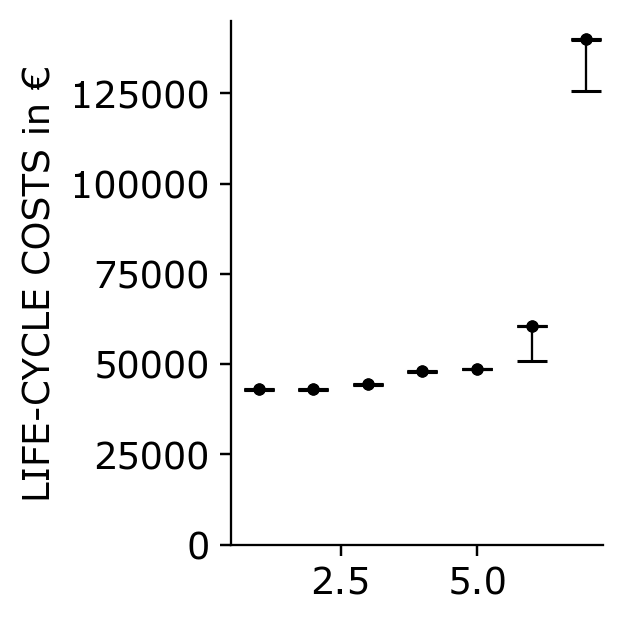

In [18]:
import matplotlib.pyplot as plt

# Assume colors are in hex RGBA
colors = ['#000000ff', '#535353ff', '#898989ff'][::-1]

# Compute indices of maximum LCC
from src.preplanning.postprocessing.utils import find_strategy_arg_min_max
arg_max_lcc, _ = find_strategy_arg_min_max(standard_dict_list, "exact_lcc")

# Plot setup
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

entry_names = ["primal solution MINLP", "primal solution MIP", "dual bound MIP"]


curr_dict = standard_dict_list[-1]
curr_dict["dual bound MIP"] = (1-curr_dict["optimality_gap"]/100)*(curr_dict["fan_energy_costs"] + curr_dict["invest_costs"])
curr_dict["primal solution MIP"] = (curr_dict["fan_energy_costs"] + curr_dict["invest_costs"])
curr_dict["primal solution MINLP"] = curr_dict["exact_lcc"]

curr_dict["mip gap abs"] = curr_dict["primal solution MIP"] - curr_dict["dual bound MIP"]
curr_dict["relax error abs"] = curr_dict["primal solution MINLP"] - curr_dict["primal solution MIP"]

# Iterate over strategies
# for idx, entry in enumerate(entry_names):
first_err = curr_dict["relax error abs"]
second_err = curr_dict["mip gap abs"] + curr_dict["relax error abs"]

ax.errorbar(range(len(first_err),0,-1), curr_dict["primal solution MINLP"], yerr=[first_err, [0]*len(first_err)], fmt='o', markersize=3, capsize=5, color= "k")

ax.errorbar(range(len(first_err),0,-1), curr_dict["primal solution MINLP"], yerr=[second_err, [0]*len(first_err)], fmt='o', markersize=3, capsize=5, color= "k")


# # Optional: Customize axes
ax.set_ylabel("LIFE-CYCLE COSTS in €")
# ax.legend(entry_names)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0.5)

fig.tight_layout()

# fig.savefig("plots/full_paper/errorbar_distributed_pareto.svg")
# fig.savefig("plots/full_paper/errorbar_distributed_pareto.pdf")
# fig.savefig("plots/full_paper/errorbar_distributed_pareto.png")

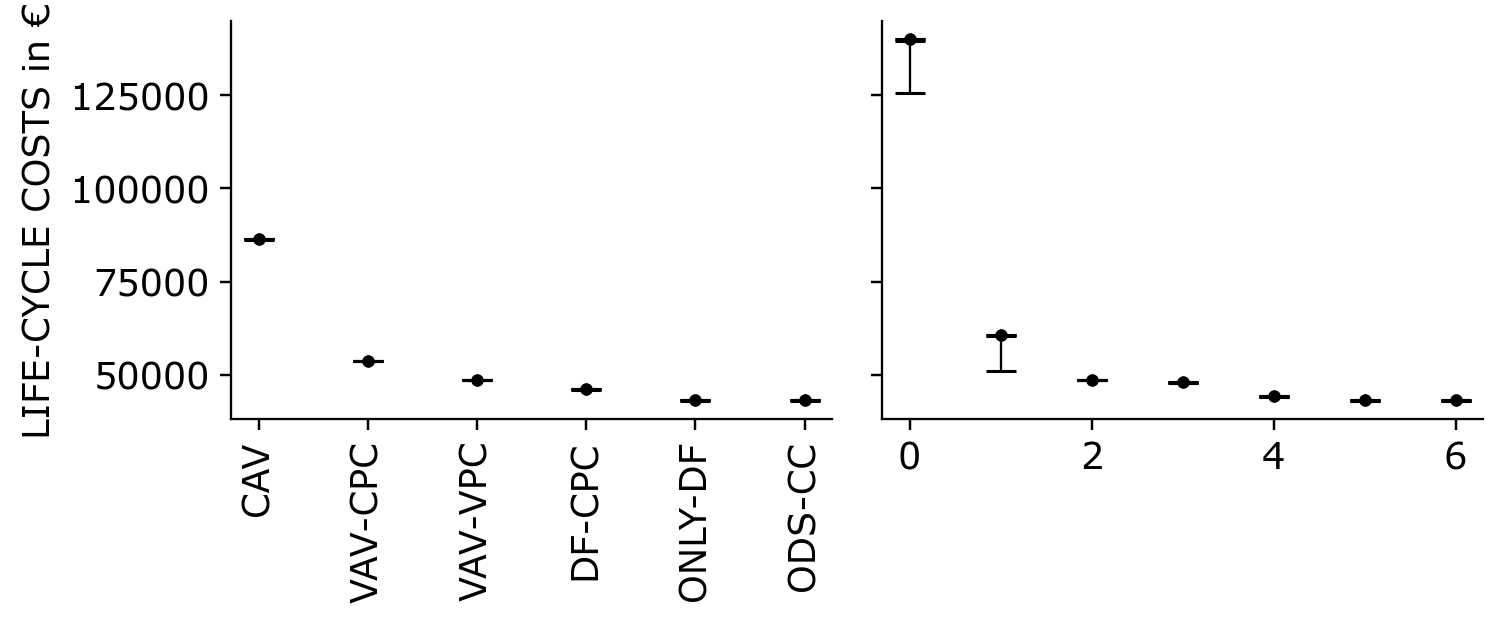

In [19]:
import matplotlib.pyplot as plt

# Assume colors are in hex RGBA
colors = ['#000000ff', '#535353ff', '#898989ff', '#b5b5b5ff',  '#dcdcdcff']

# Compute indices of maximum LCC
from src.preplanning.postprocessing.utils import find_strategy_arg_min_max
arg_max_lcc, _ = find_strategy_arg_min_max(standard_dict_list, "exact_lcc")

# Plot setup
fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

entry_names = ["primal solution MINLP", "primal solution MIP", "dual bound MIP"]


curr_dict = standard_dict_list[-1]
ax = axs[0]
# Iterate over strategies
for idx, curr_dict in enumerate(standard_dict_list):

    opt_idx = arg_max_lcc[idx]

    # Compute exact fan energy costs
    lcc_cost = curr_dict["fan_energy_costs"][opt_idx] + curr_dict["invest_costs"][opt_idx]
    dual_bound_mip = (1-curr_dict["optimality_gap"][opt_idx]/100)*(lcc_cost)
    primal_bound_mip = lcc_cost
    primal_bound_minlp = curr_dict["exact_lcc"][opt_idx]

    mip_gap = lcc_cost - dual_bound_mip
    approx_error = primal_bound_minlp - lcc_cost

    ax.errorbar(cs_names[idx], primal_bound_minlp, yerr=[[mip_gap],[0]], fmt='o', markersize=3, capsize=5, color= "k")

    ax.errorbar(cs_names[idx], primal_bound_minlp, yerr=[[approx_error], [0]], fmt='o', markersize=3, capsize=5, color= "k")


ax = axs[1]

curr_dict = standard_dict_list[-1]
curr_dict["dual bound MIP"] = (1-curr_dict["optimality_gap"]/100)*(curr_dict["fan_energy_costs"] + curr_dict["invest_costs"])
curr_dict["primal solution MIP"] = (curr_dict["fan_energy_costs"] + curr_dict["invest_costs"])
curr_dict["primal solution MINLP"] = curr_dict["exact_lcc"]

curr_dict["mip gap abs"] = curr_dict["primal solution MIP"] - curr_dict["dual bound MIP"]
curr_dict["relax error abs"] = curr_dict["primal solution MINLP"] - curr_dict["primal solution MIP"]

# Iterate over strategies
# for idx, entry in enumerate(entry_names):
first_err = curr_dict["relax error abs"]
second_err = curr_dict["mip gap abs"] + curr_dict["relax error abs"]

ax.errorbar(range(len(first_err)), curr_dict["primal solution MINLP"], yerr=[first_err, [0]*len(first_err)], fmt='o', markersize=3, capsize=5, color= "k")

ax.errorbar(range(len(first_err)), curr_dict["primal solution MINLP"], yerr=[second_err, [0]*len(first_err)], fmt='o', markersize=3, capsize=5, color= "k")




axs[0].set_ylabel("LIFE-CYCLE COSTS in €")
_ = axs[0].set_xticks(cs_names, cs_names, rotation=90)
# ax.set_ylim(bottom=0, top=144953.64152622165)

fig.tight_layout()


# fig.savefig("plots/full_paper/errorbars.svg")
# fig.savefig("plots/full_paper/errorbars.pdf")
# fig.savefig("plots/full_paper/errorbars.png")

## COmputation times

### Minimum LCC

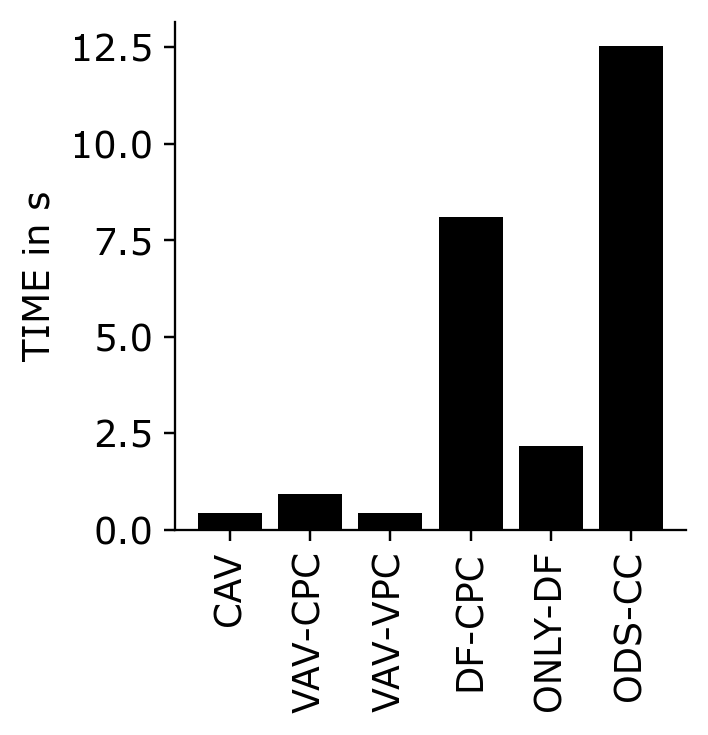

In [20]:
import matplotlib.pyplot as plt

# Assume colors are in hex RGBA
colors = ['#000000ff', '#535353ff', '#898989ff', '#b5b5b5ff', '#dcdcdcff']

# Compute indices of maximum LCC
from src.preplanning.postprocessing.utils import find_strategy_arg_min_max
arg_max_lcc, _ = find_strategy_arg_min_max(standard_dict_list, "exact_lcc")

# Plot setup
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

entry_names = ["computation_time"]


# Iterate over strategies
for idx, curr_dict in enumerate(standard_dict_list):
    # Compute exact fan energy costs
    curr_dict["exact_fan_energy_costs"] = (
        curr_dict["fan_energy_costs"]
        * curr_dict["exact_power_consumption"]
        / curr_dict["power_consumption"]
    )

    # Extract relevant costs at arg_max_lcc index
    costs = [curr_dict[name][arg_max_lcc[idx]] for name in entry_names]

    # Plot stacked bar
    b_cost = 0
    for i, cost in enumerate(costs):
        ax.bar(cs_names[idx], cost, bottom=b_cost, color=colors[i])
        b_cost += cost

# Optional: Customize axes
ax.set_ylabel("TIME in s")
# ax.legend(entry_names)

_ = ax.set_xticks(cs_names, cs_names, rotation=90)


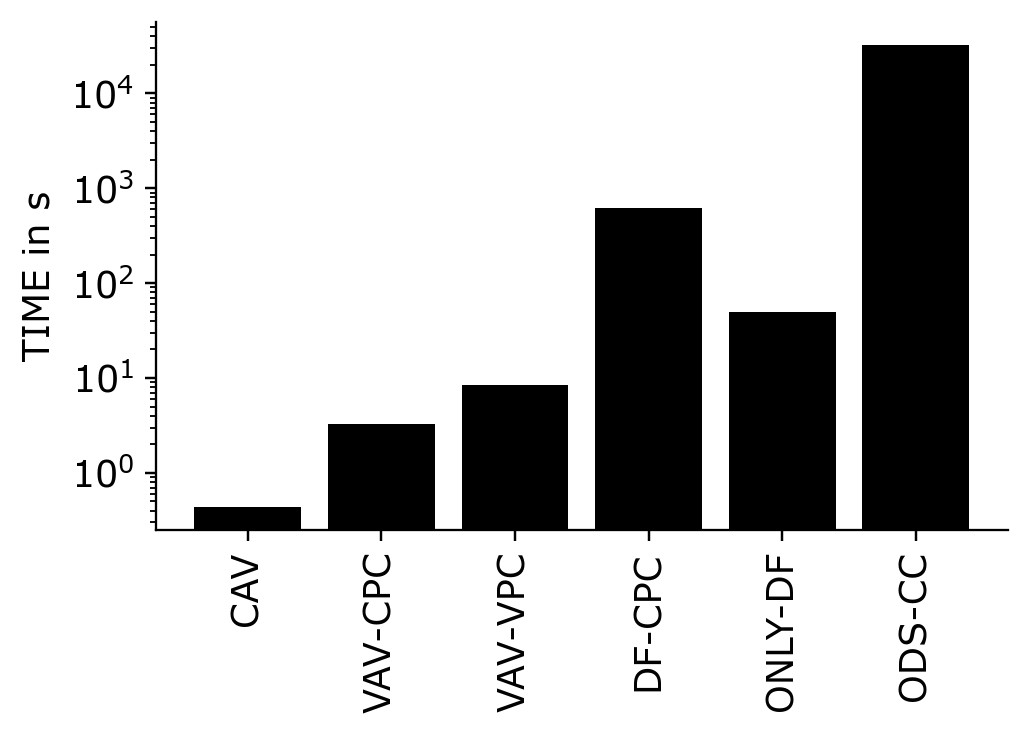

In [21]:
import matplotlib.pyplot as plt

# Assume colors are in hex RGBA
colors = ['#000000ff', '#535353ff', '#898989ff', '#b5b5b5ff', '#dcdcdcff']

# Compute indices of maximum LCC
from src.preplanning.postprocessing.utils import find_strategy_arg_min_max
arg_max_lcc, _ = find_strategy_arg_min_max(standard_dict_list, "fan_energy_costs")

# Plot setup
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

entry_names = ["computation_time"]


# Iterate over strategies
for idx, curr_dict in enumerate(standard_dict_list):
    # Compute exact fan energy costs
    curr_dict["exact_fan_energy_costs"] = (
        curr_dict["fan_energy_costs"]
        * curr_dict["exact_power_consumption"]
        / curr_dict["power_consumption"]
    )

    # Extract relevant costs at arg_max_lcc index
    costs = [curr_dict[name][arg_max_lcc[idx]] for name in entry_names]

    # Plot stacked bar
    b_cost = 0
    for i, cost in enumerate(costs):
        ax.bar(cs_names[idx], cost, bottom=b_cost, color=colors[i])
        b_cost += cost

# Optional: Customize axes
ax.set_ylabel("TIME in s")
ax.set_yscale("log")
# ax.legend(entry_names)
_ = ax.set_xticks(cs_names, cs_names, rotation=90)

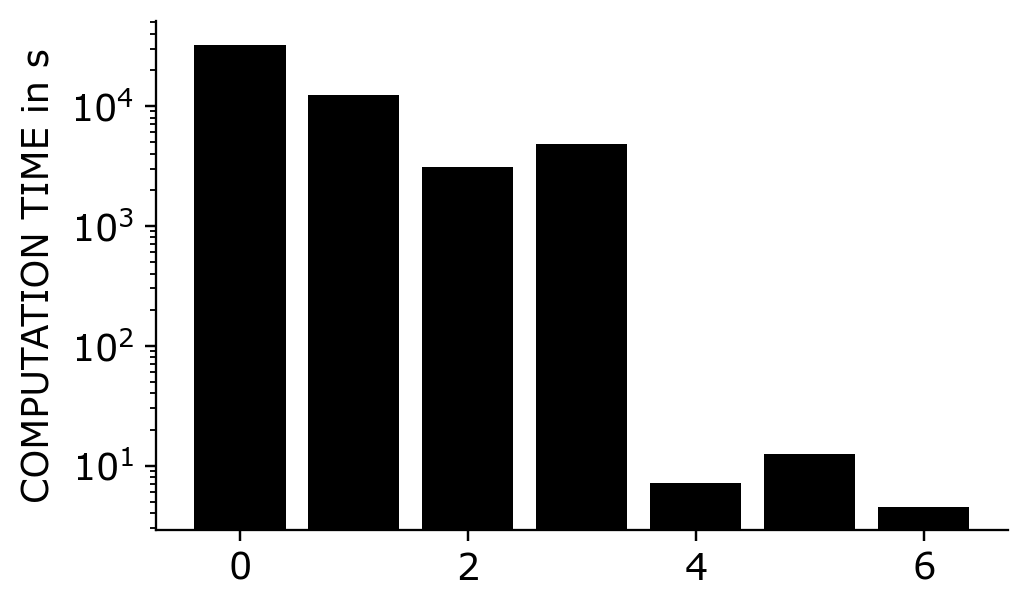

In [22]:
import matplotlib.pyplot as plt

# Assume colors are in hex RGBA
colors = ['#000000ff', '#535353ff', "white", '#898989ff', '#b5b5b5ff', '#dcdcdcff']

# Compute indices of maximum LCC
from src.preplanning.postprocessing.utils import find_strategy_arg_min_max
arg_max_lcc, _ = find_strategy_arg_min_max(standard_dict_list, "exact_lcc")

# Plot setup
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

entry_names = ["computation_time"]


curr_dict = standard_dict_list[-1]

# Iterate over strategies
for idx, entry in enumerate(entry_names):
    # Compute exact fan energy costs
    ax.bar(range(len(curr_dict["invest_costs"])),curr_dict[entry], color=colors[idx])

# # Optional: Customize axes
ax.set_ylabel("COMPUTATION TIME in s")
# ax.legend(entry_names)

ax.set_yscale("log")

# ax.set_ylim(39e3,49e3)


## Computation time plot from paper

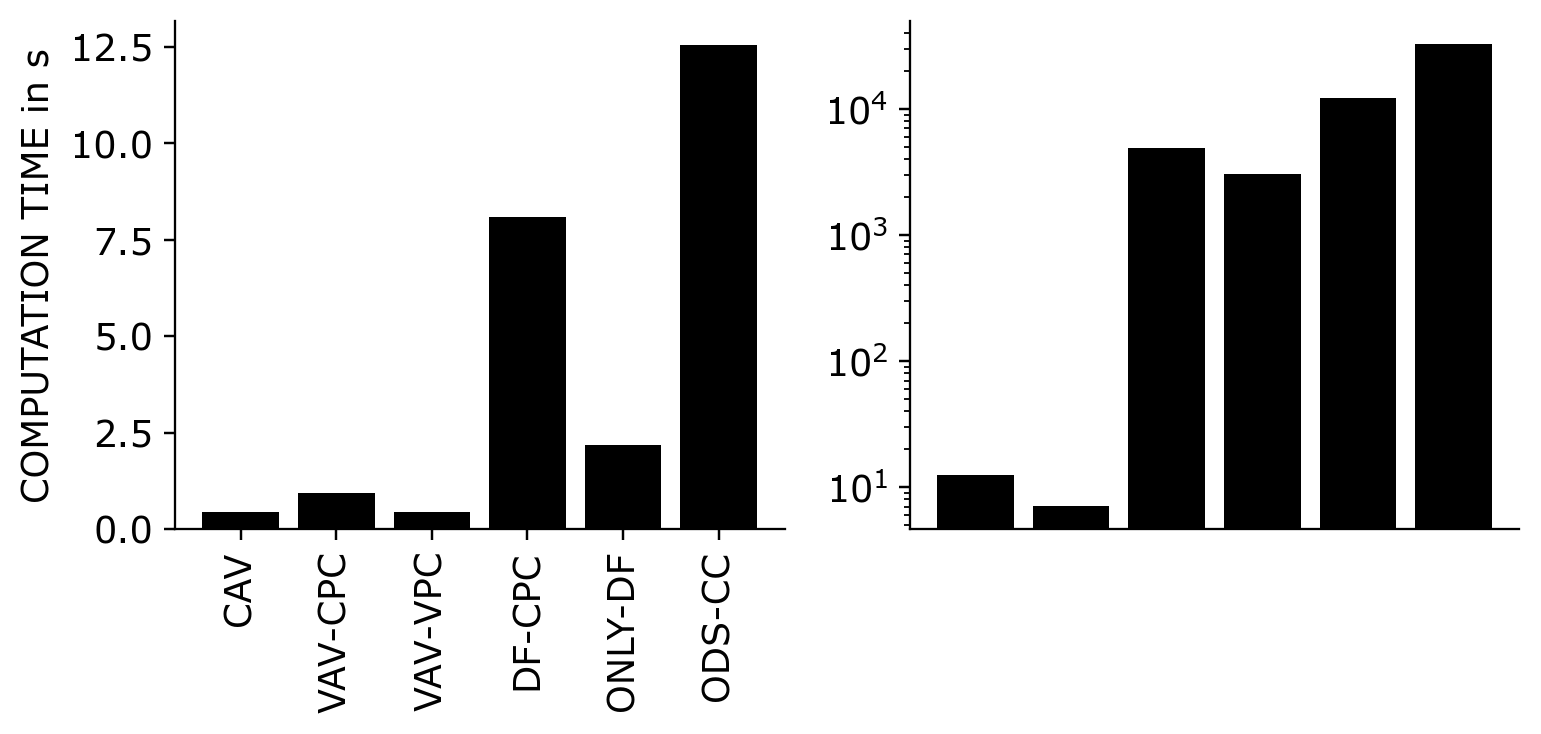

In [ ]:
import matplotlib.pyplot as plt

# Assume colors are in hex RGBA
colors = ['#000000ff', '#535353ff', '#898989ff', '#b5b5b5ff', '#dcdcdcff']

# Compute indices of maximum LCC
from src.preplanning.postprocessing.utils import find_strategy_arg_min_max
arg_max_lcc, _ = find_strategy_arg_min_max(standard_dict_list, "exact_lcc")

# Plot setup
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))

entry_names = ["computation_time"]

ax = axs[0]

# Iterate over strategies
for idx, curr_dict in enumerate(standard_dict_list):
    # Compute exact fan energy costs
    curr_dict["exact_fan_energy_costs"] = (
        curr_dict["fan_energy_costs"]
        * curr_dict["exact_power_consumption"]
        / curr_dict["power_consumption"]
    )

    # Extract relevant costs at arg_max_lcc index
    costs = [curr_dict[name][arg_max_lcc[idx]] for name in entry_names]

    # Plot stacked bar
    b_cost = 0
    for i, cost in enumerate(costs):
        ax.bar(cs_names[idx], cost, bottom=b_cost, color=colors[i])
        b_cost += cost

curr_dict = standard_dict_list[-1]

# Iterate over strategies
for idx, entry in enumerate(entry_names):
    # Compute exact fan energy costs
    axs[1].bar(range(len(curr_dict["invest_costs"])),curr_dict[entry], color=colors[idx])

axs[1].set_yscale("log")
axs[1].set_xticks([])

# Optional: Customize axes
ax.set_ylabel("COMPUTATION TIME in s")
# ax.legend(entry_names)

_ = ax.set_xticks(cs_names, cs_names, rotation=90)

fig.tight_layout()

# fig.savefig("plots/full_paper/computation_time.svg")
# fig.savefig("plots/full_paper/errorbars.pdf")
# fig.savefig("plots/full_paper/errorbars.png")